In [2]:
import numpy as np
import pandas as pd
from biom import load_table
from gneiss.util import match
from tenatch.tensor_factorization import TenAls
from tenatch.utils import table_to_tensor,tensor_rclr
from skbio import OrdinationResults, stats
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
from IPython.core.display import HTML
pd.options.mode.chained_assignment = None  # default='warn'


#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
%matplotlib inline 

In [3]:
# import the biom table
table = load_table('data/micemeth/reference-hit.biom')
# import taxa
taxa = pd.read_table('data/micemeth/taxonomy.tsv', index_col=0)
# import the metadata
meta = pd.read_table('data/micemeth/10537_20180929-125415.txt', index_col=0)

# filter sample to min depth
def sample_filter(val, id_, md): return sum(val) > 0
def observation_filter(val, id_, md): return sum(val) > 0
table = table.filter(sample_filter, axis='sample')
table = table.filter(observation_filter, axis='observation')

# ensure index matches
table,taxa = match(table.to_dataframe(),taxa)
table,meta = match(table.T,meta)

# rename table otus
table.columns=['sOTU'+str(i) for i in range(len(table.columns))]
taxa['sequence'] = taxa.index
taxa.index = table.columns

#view table
table.head(5)


,sOTU0,sOTU1,sOTU2,sOTU3,sOTU4,sOTU5,sOTU6,sOTU7,sOTU8,sOTU9,...,sOTU4690,sOTU4691,sOTU4692,sOTU4693,sOTU4694,sOTU4695,sOTU4696,sOTU4697,sOTU4698,sOTU4699
10537.p5f2.25days.saline,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p5d2.23days.saline,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1648.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p7b12.37days.saline,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,643.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p5b9.21days.saline,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3647.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10537.p3a3.253.mar6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1334.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# offspring
meta_offspring = meta[meta.treatment_group.isin(['meth.offspring','saline.offspring'])]
meta_offspring['ID'] =[x.split('.')[-1]+'_'+x.split('.')[1][3:] for x in meta_offspring.index]
# get table and filter features 
table_offspring,meta_offspring = match(table,meta_offspring)


In [5]:
%%time
# create tensor for rclr 
T, mt, colm, indm = table_to_tensor(table_offspring.copy(),
                                    meta_offspring.copy(),
                                    'ID','timepoint')
# rclr transform (flat)
T_rclr = tensor_rclr(T)
TF = TenAls(rank=3).fit(T_rclr)
# make dataframes from loadings
cols = ['PC'+str(i+1) for i in range(TF.time_loading.shape[1])]
time_loading = pd.DataFrame(TF.time_loading,sorted(mt.keys()),columns=cols)
feature_loading = pd.DataFrame(TF.feature_loading,colm,columns=cols)
sample_loading = pd.DataFrame(TF.sample_loading,indm,columns=cols)
# trajectory
traj = np.dot(TF.sample_loading,TF.time_loading.T)
traj = pd.DataFrame(traj,sample_loading.index,time_loading.index)
traj.columns.name = 'time'
traj = pd.DataFrame(traj.stack()).reset_index()
traj.columns = list(traj.columns[:-1])+['trajectory']


/Users/cameronmartino/bin/tenatch/tenatch/utils.py:23: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  if len(meta_tmp.index.get_duplicates()):


CPU times: user 1min 36s, sys: 968 ms, total: 1min 37s
Wall time: 34 s


### Qiime2: visualize trajectory in time

In [48]:
trajplot = traj.copy()
trajplot['Treatment'] = [id_.split('_')[0] for id_ in trajplot['ID']]
trajplot.columns = ['mouse_id','day','trajectory','treatment']
trajplot.index = trajplot.mouse_id + trajplot.day.astype(str)
trajplot.day = [int(t.split(' ')[0]) for t in trajplot.day]
trajplot['day'] -= min(trajplot.day)
trajplot.index.name = 'sampleid'
trajplot.to_csv('data/micemeth/offspring_trajectory.tsv',sep='\t')


In [49]:
!qiime longitudinal volatility \
    --m-metadata-file data/micemeth/offspring_trajectory.tsv \
    --p-state-column day\
    --p-individual-id-column mouse_id\
    --p-default-group-column treatment\
    --p-default-metric trajectory\
    --o-visualization data/micemeth/offspring_trajectory.qzv

Saved Visualization to: data/micemeth/offspring_trajectory.qzv


###  Qiime2:  visualize biplots

In [37]:
# sample ordination file 
taxa_off = taxa.set_index('sequence').reindex(list(feature_loading.index))
sample_loading.index.name = None
feature_loading.index.name = None
taxa_off.index.name = 'Feature ID'
feature_loading.index = taxa_off.index 
eigvals = pd.Series(TF.eigenvalues,
                        index=sample_loading.columns)
proportion_explained = pd.Series(TF.explained_variance_ratio,
                                 index=sample_loading.columns)
# save ordination results 
ord_res = OrdinationResults(
        'PCoA', 
        'Principal Coordinate Analysis',
        eigvals.copy(),
        sample_loading.copy(),
        features=feature_loading.copy(),
        proportion_explained=proportion_explained.copy())

# write files to output folder
mt['21 days'].to_csv('data/micemeth/offspring_single_time_map.tsv',sep='\t')
taxa_off.to_csv('data/micemeth/offspring_taxonomy.tsv',sep='\t')
ord_res.write('data/micemeth/rena_offspring_sample_ordination.txt')


'data/micemeth/rena_offspring_sample_ordination.txt'

In [38]:
!qiime tools import \
  --input-path data/micemeth/rena_offspring_sample_ordination.txt \
  --type 'PCoAResults % Properties("biplot")' \
  --output-path data/micemeth/rena_offspring_sample_ordination.qza

Imported data/micemeth/rena_offspring_sample_ordination.txt as OrdinationDirectoryFormat to data/micemeth/rena_offspring_sample_ordination.qza


In [39]:
!qiime tools import \
  --input-path data/micemeth/offspring_taxonomy.tsv \
  --type 'FeatureData[Taxonomy]' \
  --output-path data/micemeth/offspring_taxonomy.qza

Imported data/micemeth/offspring_taxonomy.tsv as TSVTaxonomyDirectoryFormat to data/micemeth/offspring_taxonomy.qza


In [40]:
!qiime emperor biplot \
    --i-biplot data/micemeth/rena_offspring_sample_ordination.qza \
    --m-sample-metadata-file data/micemeth/offspring_single_time_map.tsv \
    --m-feature-metadata-file  data/micemeth/offspring_taxonomy.qza \
    --o-visualization data/micemeth/offspring_biplot.qzv \
    --p-number-of-features 20

Saved Visualization to: data/micemeth/offspring_biplot.qzv


## vis in notebook

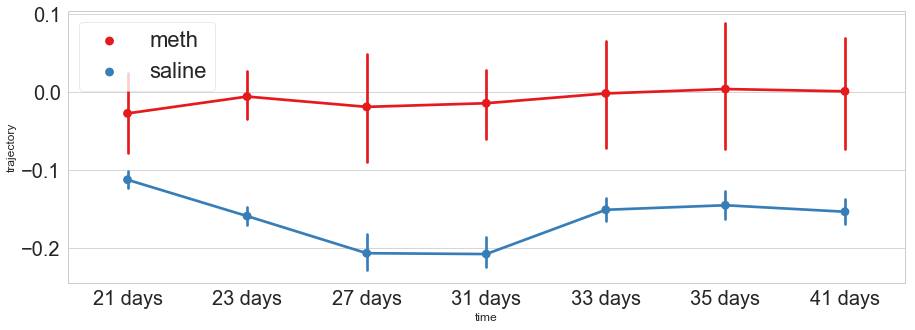

In [6]:
fig,axn = plt.subplots(1,1,figsize=(15,5))

traj['Treatment'] = [id_.split('_')[0] for id_ in traj['ID']]
axn = sns.pointplot(x="time", y="trajectory", hue="Treatment", 
              data=traj,ci=95,palette='Set1')
#axn.set_ylabel('$\\frac{Meth\,\,Enriched\,\,Microbe}{Core\,Microbe}$',fontsize=30)
#axn.set_xlabel('Day(s)',fontsize=22)
axn.legend(loc=2, prop={'size': 22})
#fig.savefig('figures/mmouse/lr_core.png',dpi=300, 
#            bbox_inches='tight',facecolor='white')
plt.show()



In [ ]:
def plot_pcoa(x, y, samples, md, ax, factor_, colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, x],
           samples.loc[idx, y], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1',fontsize=15)
    ax.set_ylabel('PC2',fontsize=15)
    
    return ax

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


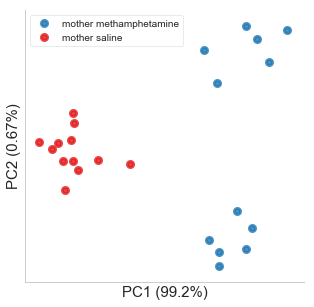

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
_ = plot_pcoa('PC1', 'PC2', sample_loading, mt['21 days'], ax, 'treated')
ax.set_xlabel('PC1 ('+str(TF.explained_variance_ratio[0]*100)[:4]+'%)',fontsize=15)
ax.set_ylabel('PC2 ('+str(TF.explained_variance_ratio[1]*100)[:4]+'%)',fontsize=15)

plt.legend()
plt.show()


### log-ratio in time

In [50]:
numerator = feature_loading.sort_values('PC1').index[-1]
# get abudnant microbe across all time
lrmetaoff = meta[meta.treatment_group.isin(['meth.offspring','saline.offspring'])]
tabledenom,_ = match(table,lrmetaoff)
denom = tabledenom.mean(axis=0).sort_values(ascending=False).index[10]
denom_opp = feature_loading.sort_values('PC1').index[2]


In [51]:
# offspring
lrmetaoff_time = {t_:match(table,tdf_) for t_,tdf_ in lrmetaoff.groupby('timepoint')}
lrmetaoff_timedf = []
for t_,tdfs_ in lrmetaoff_time.items():
    ratiodf = pd.DataFrame([np.array(np.log(tdfs_[0].loc[:,numerator]+1) - np.log(tdfs_[0].loc[:,denom]+1)).flatten(),
                            np.array(np.log(tdfs_[0].loc[:,numerator]+1) - np.log(tdfs_[0].loc[:,denom_opp]+1)).flatten(),
                            np.array(tdfs_[1]['treatment_group'].values)]).T
    ratiodf.index = tdfs_[1].index
    ratiodf.columns = ['Ratio_Core','Ratio_Opposite','Treatment']
    ratiodf['time'] = t_.split(' ')[0]
    lrmetaoff_timedf.append(ratiodf)
lrmetaoff_timedf = pd.concat(lrmetaoff_timedf,axis=0)
lrmetaoff_timedf = lrmetaoff_timedf.convert_objects(convert_numeric=True)
maptrat = {'meth.offspring':'Offspring of Meth Treated Mother', 'saline.offspring':'Offspring of Saline Treated Mother'}
lrmetaoff_timedf['Treatment'] = [maptrat[x] for x in lrmetaoff_timedf.Treatment]
 

/anaconda3/envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  del sys.path[0]


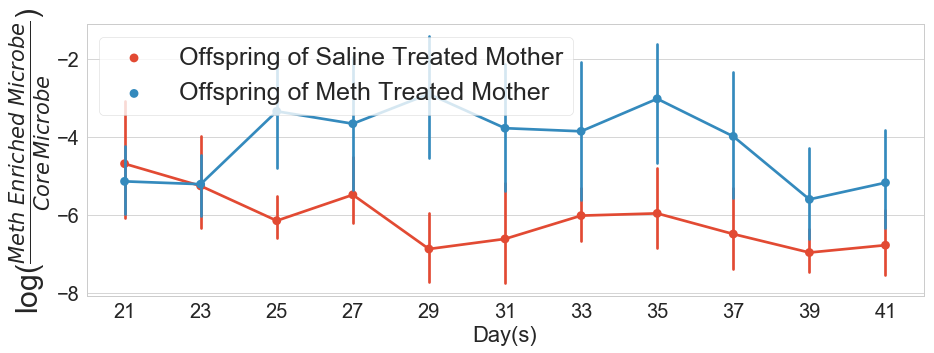

In [54]:
fig,axn = plt.subplots(1,1,figsize=(15,5))
axn = sns.pointplot(x="time", y="Ratio_Core", hue="Treatment", 
              data=lrmetaoff_timedf,ci=95)
axn.set_ylabel('log($\\frac{Meth\,\,Enriched\,\,Microbe}{Core\,Microbe}$)',fontsize=30)
axn.set_xlabel('Day(s)',fontsize=22)
axn.legend(loc=2, prop={'size': 25})
fig.savefig('figures/mmouse/lr_core.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()

